In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# First Example: XOR Network Distillation and Verification

In this notebook, we demonstrate network distillation and verification in a loop. First, we train an overparametrized network on the xor problem, graphing the decision boundary. Next we distill this network using Hinton distillation. Finally, we verify both networks using nnenum to check that the decision is stable within a certain region.

## The XOR dataset
Here is the dataset we will train with. It includes 1000 uniformly distributed samples of the xor function within the region (-1,1) of the $\mathbb{R}^2$ plane.

In [7]:
def dataset_xor_uniform(n=1000):
    i1 = np.random.random(n)*2-1
    i2 = np.random.random(n)*2-1
    target = np.logical_xor(i1>0, i2>0).astype(int)
    return np.array([i1, i2]), np.array([target])

inputs, outputs = dataset_xor_uniform()

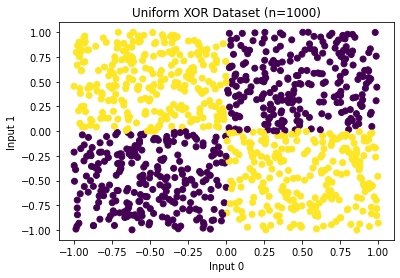

In [8]:
plt.scatter(inputs[0], inputs[1], c=outputs)
plt.title("Uniform XOR Dataset (n=1000)")
plt.xlabel("Input 0")
plt.ylabel("Input 1")
plt.show()

## Train teacher network

Now, train a fully connected neural network on this dataset with ~5,000 free parameters for 100 epochs.

In [10]:
num_observations = inputs.shape[1]
num_inputs = inputs.shape[0]
num_outputs = outputs.shape[0]

hidden_layer_width=50
num_hidden_layers=3

## Input Layer
layers = [
    tf.keras.layers.Dense(
        hidden_layer_width,
        activation=tf.nn.relu,
        input_shape=(num_inputs,),
        kernel_initializer=tf.keras.initializers.GlorotUniform(),
        bias_initializer=tf.keras.initializers.GlorotUniform()
    )
]

## Hidden Layers
for i in range(num_hidden_layers-1):
    layers.append(
        tf.keras.layers.Dense(hidden_layer_width,
            activation=tf.nn.relu,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            bias_initializer=tf.keras.initializers.GlorotUniform())
    )

## Output Layer
layers.append(tf.keras.layers.Dense(num_outputs, activation=tf.nn.relu))

model = tf.keras.Sequential(layers)

model.compile(
# loss=tf.keras.losses.BinaryCrossentropy(), # binary classification
# loss='categorical_crossentropy', # categorical classification (one hot)
loss='mean_squared_error',  # regression
optimizer=tf.keras.optimizers.Adam(0.001),
# optimizer='rmsprop',
metrics=['mean_squared_error'],
)

model.fit(
    x=inputs.T,
    y=outputs.T,
    shuffle=True,
    validation_split=.2,
    epochs=100,
    batch_size=128,
    )

model.summary()

Epoch 1/100
7/7 [==============================] - 0s 23ms/step - loss: 0.4435 - mean_squared_error: 0.4435 - val_loss: 0.3453 - val_mean_squared_error: 0.3453
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: 0.3040 - mean_squared_error: 0.3040 - val_loss: 0.2311 - val_mean_squared_error: 0.2311
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 0.2170 - mean_squared_error: 0.2170 - val_loss: 0.1965 - val_mean_squared_error: 0.1965
Epoch 4/100
7/7 [==============================] - 0s 5ms/step - loss: 0.1890 - mean_squared_error: 0.1890 - val_loss: 0.1666 - val_mean_squared_error: 0.1666
Epoch 5/100
7/7 [==============================] - 0s 10ms/step - loss: 0.1550 - mean_squared_error: 0.1550 - val_loss: 0.1330 - val_mean_squared_error: 0.1330
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 0.1233 - mean_squared_error: 0.1233 - val_loss: 0.1087 - val_mean_squared_error: 0.1087
Epoch 7/100
7/7 [===========================

313/313 [==============================] - 0s 1ms/step


/var/folders/3g/8436y4yj1r9367dvt15y6jqcdx0hcv/T/ipykernel_61116/2471555115.py:9: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx,yy,z, label="Prediction (large)")


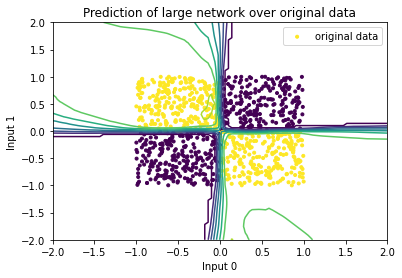

In [11]:
y_pred = model.predict(inputs.T)

X = np.linspace(-2,2,100)
Y = X.copy()
xx,yy = np.meshgrid(X,Y)
labels = model.predict(np.c_[xx.ravel(), yy.ravel()])
z = labels.reshape(xx.shape)
 
plt.contour(xx,yy,z, label="Prediction (large)")
plt.scatter(inputs[0], inputs[1], c=outputs[0], marker=".", label="original data")
plt.legend()
plt.title("Prediction of large network over original data")
plt.xlabel("Input 0")
plt.ylabel("Input 1")
plt.show()

With 20,601 trainable parameters, we are able to get a pretty good decision boundary at least for the in-sample region (-1,1). However, we can see that the network has not learned the exact XOR rule, as evidenced by some unnecessary level curves at the edges of the decision boundary. One may ask the question, does this network faithfully compute XOR throughout the entire $\mathbb{R}^2$ plane?

## Train student network using Hinton Distillation

In [12]:
## Import distiller class from example in Tensorflow documentation
from lib.knowledge_distillation import Distiller

In [13]:
num_observations = inputs.shape[1]
num_inputs = inputs.shape[0]
num_outputs = outputs.shape[0]

hidden_layer_width=10
num_hidden_layers=3

## Input Layer
layers = [
    tf.keras.layers.Dense(
        hidden_layer_width,
        activation=tf.nn.relu,
        input_shape=(num_inputs,),
        kernel_initializer=tf.keras.initializers.GlorotUniform(),
        bias_initializer=tf.keras.initializers.GlorotUniform()
    )
]

## Hidden Layers
for i in range(num_hidden_layers-1):
    layers.append(
        tf.keras.layers.Dense(hidden_layer_width,
            activation=tf.nn.relu,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            bias_initializer=tf.keras.initializers.GlorotUniform())
    )

## Output Layer
layers.append(tf.keras.layers.Dense(num_outputs, activation=tf.nn.relu))

student_model = tf.keras.Sequential(layers)

distiller = Distiller(student=student_model, teacher=model)

distiller.compile(
    student_loss_fn=tf.keras.losses.MeanSquaredError(),  # regression
    distillation_loss_fn=tf.keras.losses.KLDivergence(),  # regression
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    alpha=0.1,
    temperature=10.0
)

distiller.fit(
    x=inputs.T,
    y=outputs.T,
    # shuffle=True,
    # validation_split=.2,
    epochs=100,
    # batch_size=128,
    )


Epoch 1/100
32/32 [==============================] - 1s 1ms/step - mean_squared_error: 0.2847 - student_loss: 0.2833 - distillation_loss: 0.0000e+00
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - mean_squared_error: 0.2140 - student_loss: 0.2126 - distillation_loss: 0.0000e+00
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - mean_squared_error: 0.1705 - student_loss: 0.1712 - distillation_loss: 0.0000e+00
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - mean_squared_error: 0.1326 - student_loss: 0.1289 - distillation_loss: 0.0000e+00
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - mean_squared_error: 0.1026 - student_loss: 0.1001 - distillation_loss: 0.0000e+00
Epoch 6/100
32/32 [==============================] - 0s 1ms/step - mean_squared_error: 0.0850 - student_loss: 0.0864 - distillation_loss: 0.0000e+00
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - mean_squared_error: 0.0747 - student_lo

In [14]:
student_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                30        
                                                                 
 dense_13 (Dense)            (None, 10)                110       
                                                                 
 dense_14 (Dense)            (None, 10)                110       
                                                                 
 dense_15 (Dense)            (None, 1)                 11        
                                                                 
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


313/313 [==============================] - 0s 755us/step


/var/folders/3g/8436y4yj1r9367dvt15y6jqcdx0hcv/T/ipykernel_61116/635805078.py:7: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx,yy,z, label="Prediction (large)")


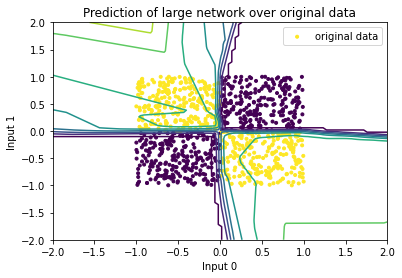

In [15]:
X = np.linspace(-2,2,100)
Y = X.copy()
xx,yy = np.meshgrid(X,Y)
labels = student_model.predict(np.c_[xx.ravel(), yy.ravel()])
z = labels.reshape(xx.shape)
 
plt.contour(xx,yy,z, label="Prediction (large)")
plt.scatter(inputs[0], inputs[1], c=outputs[0], marker=".", label="original data")
plt.legend()
plt.title("Prediction of large network over original data")
plt.xlabel("Input 0")
plt.ylabel("Input 1")
plt.show()

# Verify both networks

Assert that the decision is correct inside each quadrant (with some padding)?

Constant Padding
- Q1: Input 0 > 0.5 and Input 1 > 0.5 => Output 0 == False
- Q2: Input 0 > 0.5 and Input 1 < -0.5 => Output 0 == True
- Q3: Input 0 < -0.5 and Input 1 < -0.5 => Output 0 == False
- Q4: Input 0 > 0.5 and Input 1 < -0.5 => Output 0 == True

Proportional Padding
- Q1: Input 0 > 1/1000 * Input 1 and Input 1 > 1/1000 * Input 0 => Output 0 == False
- Q2: Input 0 > 1/1000 * Input 1 and Input 1 < -1/1000 * Input 0 == True
- Q3: Input 0 < -1/1000 * Input 1 and Input 1 < -1/1000 * Input 0 == False
- Q4: Input 0 > 1/1000 * Input 1 and Input 1 < -1/1000 * Input 0 == True

## Data Driven Method
Ensure that every data point in the dataset satisfying the preconditions evaluate to the correct output.


In [16]:
padding = 0.5

# This property list is of the format:
# (Name of property, region of input for which it must apply, output value
properties = (
    ("Q1", inputs[:,(inputs[0] > padding) & (inputs[1] > padding)], False),
    ("Q2", inputs[:,(inputs[0] < -padding) & (inputs[1] > padding)], True),
    ("Q3", inputs[:,(inputs[0] < -padding) & (inputs[1] < -padding)], False),
    ("Q4", inputs[:,(inputs[0] > padding) & (inputs[1] < -padding)], True),
)

for model_name, the_model in [("student", student_model), ("teacher", model)]:
    print(f"Inspecting {model_name}")
    for property_name, property_data, property_output in properties:
        prediction = the_model.predict(property_data.T)
        assert (np.abs(prediction - property_output)<0.1).all() , f"{property_name} failed"
        print(f"Model {model_name}, {property_name} property passed!")

Inspecting student
2/2 [==============================] - 0s 2ms/step
Model student, Q1 property passed!
3/3 [==============================] - 0s 1ms/step
Model student, Q2 property passed!
2/2 [==============================] - 0s 2ms/step
Model student, Q3 property passed!
2/2 [==============================] - 0s 2ms/step
Model student, Q4 property passed!
Inspecting teacher
2/2 [==============================] - 0s 2ms/step
Model teacher, Q1 property passed!
3/3 [==============================] - 0s 2ms/step
Model teacher, Q2 property passed!
2/2 [==============================] - 0s 2ms/step
Model teacher, Q3 property passed!
2/2 [==============================] - 0s 2ms/step
Model teacher, Q4 property passed!


## Probabilistic Method
Ensure that a random samples from within the precondition produce the correct output.

In [17]:
padding = 0.1
max_distance = 2.0
samples = 1000

# This property list is of the format:
# (Name of property, region of input for which it must apply, output value
properties = [
    ("Q1", np.array([np.random.uniform(padding, max_distance, samples),
                    np.random.uniform(padding,max_distance,samples)]), False)
]

for model_name, the_model in [("student", student_model), ("teacher", model)]:
    print(f"Inspecting {model_name}")
    for property_name, property_data, property_output in properties:
        prediction = the_model.predict(property_data.T)
        errors = (np.abs(prediction - property_output) < 0.1)
        if not errors.all():
            print(f"{property_name} failed")
            print(property_data[:,errors.flatten()==False])
            continue
        print(f"Model {model_name}, {property_name} property passed!")

Inspecting student
32/32 [==============================] - 0s 905us/step
Q1 failed
[[0.16280821 0.10730624 0.15013088 0.18844997 0.12282287 0.14237667
  0.15970728 0.11238123 0.13092208 0.16391227 0.10960316 0.17815483]
 [1.84605987 1.50029784 1.76233046 1.93190365 1.66620002 1.75117752
  1.94980456 1.78440209 1.62117722 1.83889898 1.99532047 1.98631881]]
Inspecting teacher
32/32 [==============================] - 0s 865us/step
Q1 failed
[[1.9970791 ]
 [0.10328627]]


## Analytic Method
Ensure that all points within the precondition produce the correct output.

### Using abstraction
### Complete


## NNenum

In [18]:
tf.saved_model.save(student_model, "./distill_test_student_model")
tf.saved_model.save(model, "./distill_test_model")

INFO:tensorflow:Assets written to: ./distill_test_student_model/assets
INFO:tensorflow:Assets written to: ./distill_test_model/assets


In [19]:
!python -m tf2onnx.convert --saved-model ./distill_test_model/ --output distill_test_model.onnx --opset 11
!python -m tf2onnx.convert --saved-model ./distill_test_student_model/ --output distill_test_student_model.onnx --opset 11

/Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-07-08 11:46:08,182 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-07-08 11:46:08,413 - INFO - Signatures found in model: [serving_default].
2022-07-08 11:46:08,413 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-07-08 11:46:08,413 - INFO - Output names: ['dense_11']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-07-08 11:46:08,476 - WARNING - From /Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/site-packages/tf2onnx/tf_loader.py:711: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.com

In [28]:
property = """
; Q1 Property

(declare-const X_0 Real)
(declare-const X_1 Real)

(declare-const Y_0 Real)
(declare-const Y_1 Real)
(declare-const Y_2 Real)
(declare-const Y_3 Real)


(assert (>= X_0 0.2))
(assert (<= X_0 1000.0))
(assert (>= X_1 0.2))
(assert (<= X_1 1000.0))

(assert (>= Y_0 0.5))
"""

with open("distill_test.vnnlib", "w") as file:
    file.write(property)


In [29]:
!docker run -it -v $(PWD):/my_work nnenum_image python3 -m nnenum.nnenum /my_work/distill_test_model.onnx /my_work/distill_test.vnnlib

all input names: ['dense_8_input', 'StatefulPartitionedCall/sequential_2/dense_8/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential_2/dense_8/MatMul:0', 'StatefulPartitionedCall/sequential_2/dense_8/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential_2/dense_8/BiasAdd:0', 'StatefulPartitionedCall/sequential_2/dense_8/Relu:0', 'StatefulPartitionedCall/sequential_2/dense_9/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential_2/dense_9/MatMul:0', 'StatefulPartitionedCall/sequential_2/dense_9/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential_2/dense_9/BiasAdd:0', 'StatefulPartitionedCall/sequential_2/dense_9/Relu:0', 'StatefulPartitionedCall/sequential_2/dense_10/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential_2/dense_10/MatMul:0', 'StatefulPartitionedCall/sequential_2/dense_10/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential_2/dense_10/BiasAdd:0', 'StatefulPartitionedCall/sequential_2/dense_10/Relu:0', 'StatefulPartit